# Turtle Games

__Analysis of Customer Data__

Here we analyse the customer data provided by Turtle Games, aiming to provide insight into:
- the accumulation of loyalty points
- the different groups that exist within the customer base
- the sentiment from customer product reviews

## Prepare data

Here we will load and explore the customer data.

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud 
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from collections import Counter
from textblob import TextBlob
import warnings
warnings.simplefilter(action='ignore')

In [2]:
# Load the data 
turtle_reviews = pd.read_csv('turtle_reviews.csv')
turtle_reviews.head()

,gender,age,remuneration (k£),spending_score (1-100),loyalty_points,education,language,platform,product,review,summary
0,Male,18,12.30,39,210,graduate,EN,Web,453,"When it comes to a DM's screen, the space on t...",The fact that 50% of this space is wasted on a...
1,Male,23,12.30,81,524,graduate,EN,Web,466,An Open Letter to GaleForce9*:\n\nYour unpaint...,Another worthless Dungeon Master's screen from...
2,Female,22,13.12,6,40,graduate,EN,Web,254,"Nice art, nice printing. Why two panels are f...","pretty, but also pretty useless"
3,Female,25,13.12,77,562,graduate,EN,Web,263,Amazing buy! Bought it as a gift for our new d...,Five Stars
4,Female,33,13.94,40,366,graduate,EN,Web,291,As my review of GF9's previous screens these w...,Money trap


In [3]:
# Check for missing values
turtle_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gender                  2000 non-null   object 
 1   age                     2000 non-null   int64  
 2   remuneration (k£)       2000 non-null   float64
 3   spending_score (1-100)  2000 non-null   int64  
 4   loyalty_points          2000 non-null   int64  
 5   education               2000 non-null   object 
 6   language                2000 non-null   object 
 7   platform                2000 non-null   object 
 8   product                 2000 non-null   int64  
 9   review                  2000 non-null   object 
 10  summary                 2000 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 172.0+ KB


In [4]:
# View descriptive statistics
turtle_reviews.describe()

,age,remuneration (k£),spending_score (1-100),loyalty_points,product
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,39.495000,48.079060,50.000000,1578.032000,4320.521500
std,13.573212,23.123984,26.094702,1283.239705,3148.938839
min,17.000000,12.300000,1.000000,25.000000,107.000000
25%,29.000000,30.340000,32.000000,772.000000,1589.250000
50%,38.000000,47.150000,50.000000,1276.000000,3624.000000
75%,49.000000,63.960000,73.000000,1751.250000,6654.000000
max,72.000000,112.340000,99.000000,6847.000000,11086.000000


Female    1120
Male       880
Name: gender, dtype: int64 

graduate        900
PhD             460
postgraduate    400
diploma         190
Basic            50
Name: education, dtype: int64 

EN    2000
Name: language, dtype: int64 

Web    2000
Name: platform, dtype: int64 

love it                                                                                                                                                                                                                                                                                                                                                     5
great game                                                                                                                                                                                                                                                                                                                                                  3
Love it                 

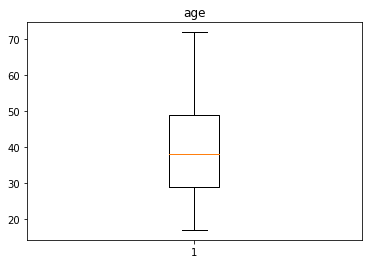

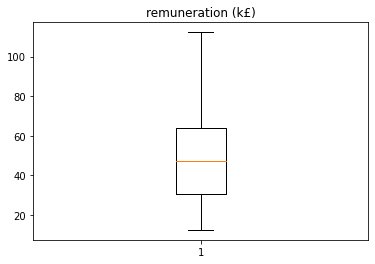

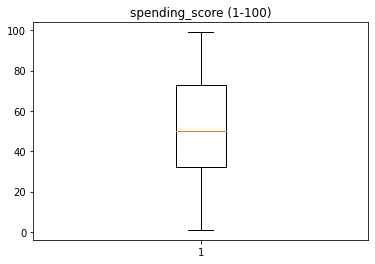

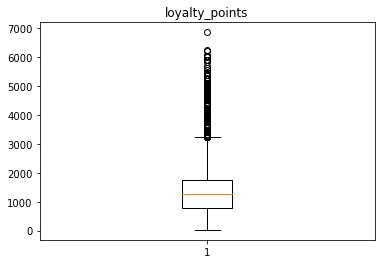

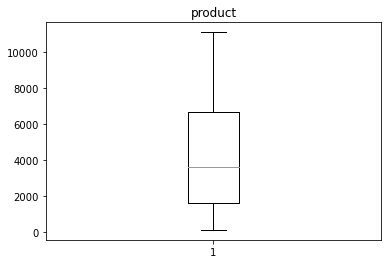

In [5]:
# Explore data (values for categorical data, boxplots for numerical data)

for col in turtle_reviews.columns:
    if turtle_reviews[col].dtype == 'object':
        print(turtle_reviews[col].value_counts(),'\n')
    else:
        fig, ax = plt.subplots()
        ax.set_title(col)
        ax.boxplot(turtle_reviews[col])

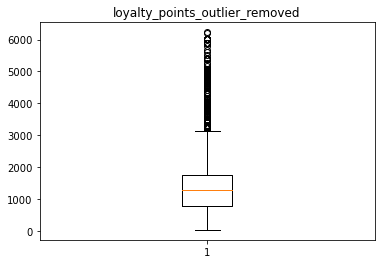

,age,remuneration (k£),spending_score (1-100),loyalty_points,product
count,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000
mean,39.492246,48.046913,49.983492,1575.396198,4320.942971
std,13.576050,23.085027,26.090783,1278.133975,3149.670337
min,17.000000,12.300000,1.000000,25.000000,107.000000
25%,29.000000,30.340000,32.000000,772.000000,1586.500000
50%,38.000000,46.740000,50.000000,1274.000000,3629.000000
75%,49.000000,63.960000,73.000000,1748.500000,6662.000000
max,72.000000,112.340000,99.000000,6232.000000,11086.000000


In [6]:
# Handling outliers

# Remove one extreme outlier visually identified in loyalty_points boxplot
turtle_reviews = turtle_reviews[turtle_reviews['loyalty_points']<turtle_reviews['loyalty_points'].max()]

# View updated boxplot
plt.boxplot(turtle_reviews['loyalty_points'])
plt.title('loyalty_points_outlier_removed')
plt.show()

# View updated descriptive statistics
turtle_reviews.describe()

In [7]:
# View column names
print(turtle_reviews.columns)

# Drop unnecessary columns
turtle_reviews.drop(['language', 'platform'], axis=1, inplace=True)

# Rename columns to simpler version 
turtle_reviews.rename(columns={'remuneration (k£)' : 'remuneration', 'spending_score (1-100)' : 'spending_score'}, inplace=True)

# View updated column names
turtle_reviews.columns

Index(['gender', 'age', 'remuneration (k£)', 'spending_score (1-100)',
       'loyalty_points', 'education', 'language', 'platform', 'product',
       'review', 'summary'],
      dtype='object')


Index(['gender', 'age', 'remuneration', 'spending_score', 'loyalty_points',
       'education', 'product', 'review', 'summary'],
      dtype='object')

In [8]:
# Save updated dataframe 
turtle_reviews.to_csv('reviews.csv', index=False)

# Import saved file
reviews = pd.read_csv('reviews.csv')

# View data
print(reviews.shape)
print(reviews.info())
reviews.head()

(1999, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          1999 non-null   object 
 1   age             1999 non-null   int64  
 2   remuneration    1999 non-null   float64
 3   spending_score  1999 non-null   int64  
 4   loyalty_points  1999 non-null   int64  
 5   education       1999 non-null   object 
 6   product         1999 non-null   int64  
 7   review          1999 non-null   object 
 8   summary         1999 non-null   object 
dtypes: float64(1), int64(4), object(4)
memory usage: 140.7+ KB
None


,gender,age,remuneration,spending_score,loyalty_points,education,product,review,summary
0,Male,18,12.30,39,210,graduate,453,"When it comes to a DM's screen, the space on t...",The fact that 50% of this space is wasted on a...
1,Male,23,12.30,81,524,graduate,466,An Open Letter to GaleForce9*:\n\nYour unpaint...,Another worthless Dungeon Master's screen from...
2,Female,22,13.12,6,40,graduate,254,"Nice art, nice printing. Why two panels are f...","pretty, but also pretty useless"
3,Female,25,13.12,77,562,graduate,263,Amazing buy! Bought it as a gift for our new d...,Five Stars
4,Female,33,13.94,40,366,graduate,291,As my review of GF9's previous screens these w...,Money trap


#### Summary

We have explored the data, and confirmed that there are no missing values. 

No outliers were identified in age, remuneration, or spending_score. A boxplot identified some high outliers in loyalty_points, and one extreme outlier was removed.

We are left with 1999 data points. 

## Loyalty Points

Here we use simple and multiple linear regression methods to investigate the accumulation of loyalty points. 

#### Simple Linear Regression

In [9]:
# Simple linear regression function 

def linear_regression(x, y=reviews.loyalty_points):
    print(f'Linear Regression with x={x.name} and y={y.name}: \n')
    print(np.corrcoef(x, y))
    test = ols('y ~ x', data=reviews).fit()
    display(test.summary())
    y_pred = test.params[0] + test.params[1]*x
    plt.scatter(x, y)  
    plt.xlabel(f'{x.name}')
    plt.ylabel(f'{y.name}')
    plt.title(f'Relationship between {x.name} and {y.name}')
    plt.plot(x, y_pred, color='orange', linewidth=2) 

Linear Regression with x=age and y=loyalty_points: 

[[ 1.         -0.04346367]
 [-0.04346367  1.        ]]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.780
Date:                Sun, 11 Sep 2022   Prob (F-statistic):             0.0520
Time:                        22:29:29   Log-Likelihood:                -17133.
No. Observations:                1999   AIC:                         3.427e+04
Df Residuals:                    1997   BIC:                         3.428e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1736.9961     87.894     19.762      0.000    1564.623    1909.369
x             -4.0919      2.105     -1.944      0.052      -8.220       0.036
==============================================================================
Omnibus:                      473.895   Durbin-Watson:                   2.275
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              910.289
Skew:                           1.438   Prob(JB):                    2.15e-198
Kurtosis:                       4.631   Cond. No.                         129.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

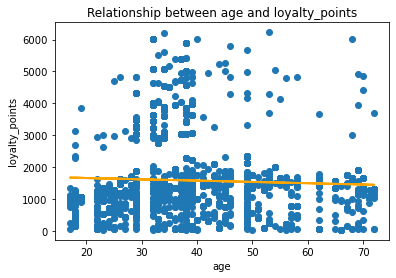

In [10]:
# Age and loyalty points
linear_regression(reviews.age)

Linear Regression with x=remuneration and y=loyalty_points: 

[[1.         0.61413334]
 [0.61413334 1.        ]]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     1209.
Date:                Sun, 11 Sep 2022   Prob (F-statistic):          1.41e-207
Time:                        22:29:29   Log-Likelihood:                -16662.
No. Observations:                1999   AIC:                         3.333e+04
Df Residuals:                    1997   BIC:                         3.334e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -58.3108     52.119     -1.119      0.263    -160.523      43.902
x             34.0023      0.978     34.775      0.000      32.085      35.920
==============================================================================
Omnibus:                       21.164   Durbin-Watson:                   3.621
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.122
Skew:                           0.095   Prob(JB):                     1.75e-07
Kurtosis:                       3.581   Cond. No.                         123.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

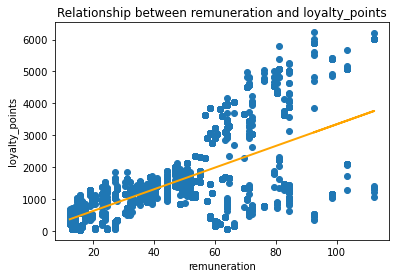

In [11]:
# Remuneration and loyalty points
linear_regression(reviews.remuneration)

Linear Regression with x=spending_score and y=loyalty_points: 

[[1.        0.6728241]
 [0.6728241 1.       ]]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     1652.
Date:                Sun, 11 Sep 2022   Prob (F-statistic):          1.12e-263
Time:                        22:29:29   Log-Likelihood:                -16533.
No. Observations:                1999   AIC:                         3.307e+04
Df Residuals:                    1997   BIC:                         3.308e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -72.0734     45.724     -1.576      0.115    -161.745      17.598
x             32.9603      0.811     40.642      0.000      31.370      34.551
==============================================================================
Omnibus:                      116.052   Durbin-Watson:                   1.183
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              230.655
Skew:                           0.400   Prob(JB):                     8.20e-51
Kurtosis:                       4.459   Cond. No.                         122.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

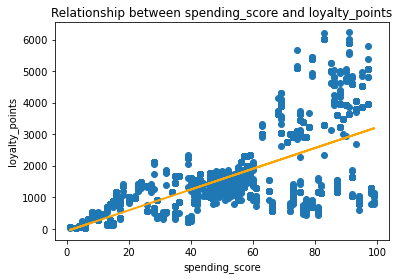

In [12]:
# Spending score and loyalty points
linear_regression(reviews.spending_score)

#### Multiple Linear Regression 

In [13]:
# Multiple linear regression function 
def multiple_linear_model(X, y=reviews.loyalty_points):
    
    # Multiple linear regression 
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)
    mlr_model = sm.OLS(y_train, sm.add_constant(x_train)).fit()
    y_pred = mlr_model.predict(sm.add_constant(x_test))     
    # Model summary, including R squared 
    display(mlr_model.summary())
    
    # Check heteroscedasticity
    het_model = sms.het_breuschpagan(mlr_model.resid, mlr_model.model.exog) 
    print(f'LM stat: {het_model[0]}, LM p-value: {het_model[1]}')
    
    # Plot residuals
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals)
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.show()
    # Distribution of residuals
    plt.hist(residuals)
    plt.title('Histogram of residuals')
    plt.show()
    
    # Check multicollinearity
    x_data = sm.add_constant(x_train)
    vif_df = pd.DataFrame()
    vif_df['VIF'] = [vif(x_data.values, i) for i in range(x_data.values.shape[1])]
    vif_df['Feature'] = x_data.columns
    display(vif_df)
    
    # Evaluate model
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
    print('Mean Square Error:', metrics.mean_squared_error(y_test, y_pred)) 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         loyalty_points   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     2792.
Date:                Sun, 11 Sep 2022   Prob (F-statistic):               0.00
Time:                        22:29:29   Log-Likelihood:                -12230.
No. Observations:                1599   AIC:                         2.447e+04
Df Residuals:                    1595   BIC:                         2.449e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2198.8313     58.296    -37.719      0.000   -2313.175   -2084.487
age               10.7195      0.964     11.119      0.000       8.829      12.611
remuneration      34.3398      0.557     61.692      0.000      33.248      35.432
spending_score    33.9215      0.503     67.393      0.000      32.934      34.909
==============================================================================
Omnibus:                       12.160   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               12.921
Skew:                           0.171   Prob(JB):                      0.00156
Kurtosis:                       3.278   Cond. No.                         380.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

LM stat: 32.03651499663568, LM p-value: 5.14154654616702e-07


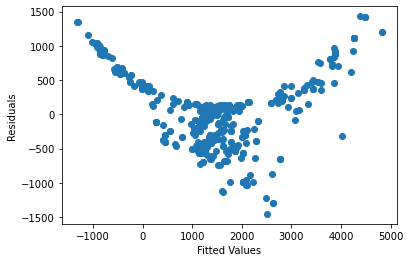

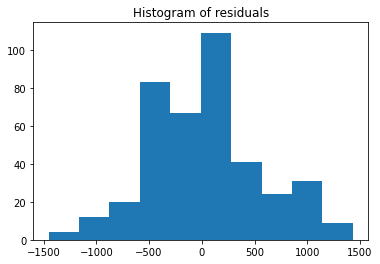

,VIF,Feature
0,21.035118,const
1,1.058692,age
2,1.000059,remuneration
3,1.058631,spending_score


Mean Absolute Error: 410.68214750793385
Mean Square Error: 279177.2263792361


In [14]:
# Try age, remuneration, and spending_score
multiple_linear_model(reviews[['age', 'remuneration', 'spending_score']])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         loyalty_points   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     2107.
Date:                Sun, 11 Sep 2022   Prob (F-statistic):               0.00
Time:                        22:29:30   Log-Likelihood:                -12226.
No. Observations:                1599   AIC:                         2.446e+04
Df Residuals:                    1594   BIC:                         2.449e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2248.8955     60.482    -37.183      0.000   -2367.527   -2130.264
age               10.8834      0.963     11.299      0.000       8.994      12.773
remuneration      34.3895      0.555     61.910      0.000      33.300      35.479
spending_score    33.8981      0.502     67.508      0.000      32.913      34.883
female            76.9138     25.557      3.010      0.003      26.785     127.042
==============================================================================
Omnibus:                       12.164   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               12.847
Skew:                           0.173   Prob(JB):                      0.00162
Kurtosis:                       3.270   Cond. No.                         398.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

LM stat: 32.662103857932465, LM p-value: 1.400680837298897e-06


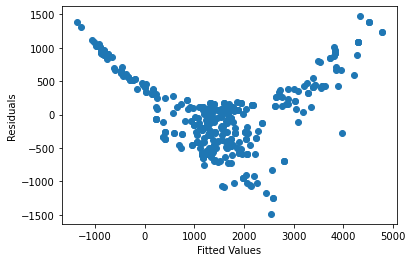

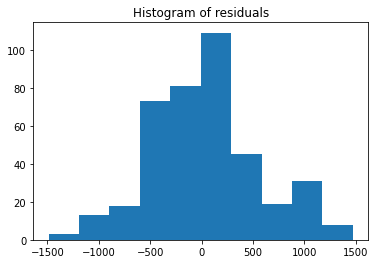

,VIF,Feature
0,22.756667,const
1,1.062087,age
2,1.000944,remuneration
3,1.058886,spending_score
4,1.004998,female


Mean Absolute Error: 407.24938512283484
Mean Square Error: 277735.0212465621


In [15]:
# Try age, remuneration, spending_score, and female
reviews['female'] = np.where(reviews['gender']=='Female', 1, 0)
multiple_linear_model(reviews[['age', 'remuneration', 'spending_score', 'female']])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         loyalty_points   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     3865.
Date:                Sun, 11 Sep 2022   Prob (F-statistic):               0.00
Time:                        22:29:30   Log-Likelihood:                -4730.1
No. Observations:                1599   AIC:                             9470.
Df Residuals:                    1594   BIC:                             9497.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -11.7737      0.557    -21.141      0.000     -12.866     -10.681
age                0.1527      0.009     17.212      0.000       0.135       0.170
remuneration       0.4077      0.005     79.707      0.000       0.398       0.418
spending_score     0.4393      0.005     95.019      0.000       0.430       0.448
female             1.3981      0.235      5.941      0.000       0.936       1.860
==============================================================================
Omnibus:                      298.881   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              490.357
Skew:                          -1.243   Prob(JB):                    3.31e-107
Kurtosis:                       4.086   Cond. No.                         398.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

LM stat: 5.735025991183756, LM p-value: 0.21982987396763343


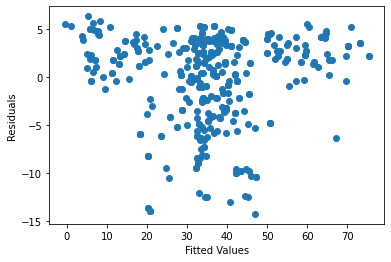

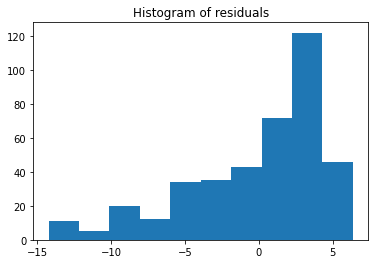

,VIF,Feature
0,22.756667,const
1,1.062087,age
2,1.000944,remuneration
3,1.058886,spending_score
4,1.004998,female


Mean Absolute Error: 3.722848933459228
Mean Square Error: 21.47214321694704


In [16]:
# Try with square root loyalty_points
multiple_linear_model(reviews[['age', 'remuneration', 'spending_score', 'female']], \
                     np.sqrt(reviews['loyalty_points']))

#### Summary

We found that age, remuneration, spending_score, and gender were all significant variables in a model to predict loyalty_points (p < 0.05). There was evidence of heteroscedasticity in the original model (LM p-value < 0.05), so the model was adjusted to predict the square root of loyalty_points instead. 

This final model has a strong adjusted R squared value of 90.6%, and can be used to predict customer loyalty_points using the age, remuneration, spending_score, and gender. 

$\sqrt{loyalty\_points} = 0.1527(age) + 0.4077(remuneration) + 0.4393(spending\_score) + 1.3981(female) - 11.7737$


## Customer Groups 

Here we use k-means clustering to identify different groups of customers by remuneration and spending score. 

In [17]:
# Investigate remuneration and spending score 
cluster_df = reviews[['remuneration', 'spending_score']]

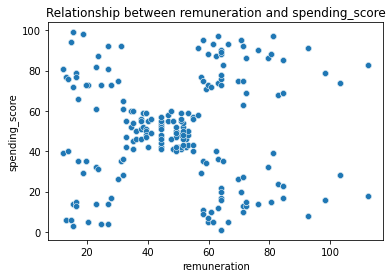

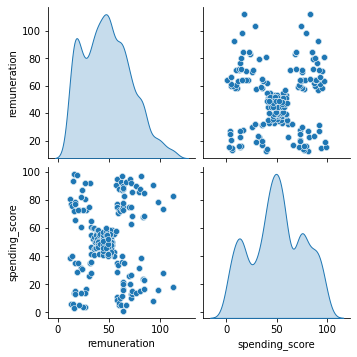

In [18]:
# Plot the relationships 
sns.scatterplot(x='remuneration', y='spending_score', data=cluster_df) \
.set_title('Relationship between remuneration and spending_score')
sns.pairplot(cluster_df, vars=cluster_df, diag_kind='kde')

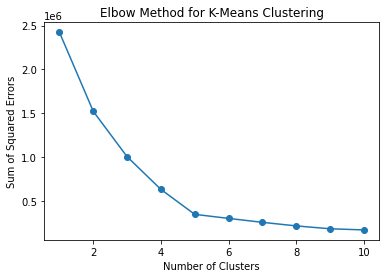

In [19]:
# Elbow method to determine K 
sse = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 6)
    kmeans.fit(cluster_df)
    sse.append(kmeans.inertia_)   
# Plot    
plt.plot(range(1, 11), sse, marker='o')
plt.title("Elbow Method for K-Means Clustering")
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Errors")
plt.show()

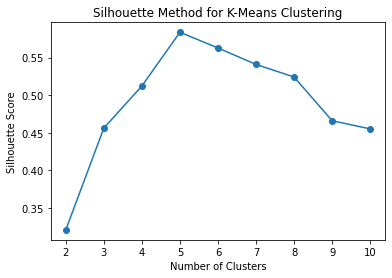

In [20]:
# Silhouette method to determine K
sil = []
kmax = 10
for k in range(2, kmax+1):
    kmeans_s = KMeans(n_clusters = k).fit(cluster_df)
    labels = kmeans_s.labels_
    sil.append(silhouette_score(cluster_df, labels, metric = 'euclidean'))
# Plot 
plt.plot(range(2, kmax+1), sil, marker='o')
plt.title("Silhouette Method for K-Means Clustering")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

In [21]:
# Function to plot result for K clusters 

def plot_k_clusters(num_clusters):
    # Set clusters
    k_means = KMeans(n_clusters = num_clusters, max_iter = 15000, init='k-means++', random_state=6).fit(cluster_df)
    cluster_df_copy = cluster_df.copy()
    cluster_df_copy['K_Means_Predicted'] = k_means.labels_
    # Display pairplot
    sns.pairplot(cluster_df_copy, hue='K_Means_Predicted', diag_kind= 'kde') \
    .fig.suptitle(f"Pairplot with {num_clusters} Clusters", x=0.45, y=1.05)
    # Display amount in each cluster 
    print('Number of customers in each cluster:')
    print(cluster_df_copy['K_Means_Predicted'].value_counts())
    
    return cluster_df_copy

Number of customers in each cluster:
1    1013
0     355
2     351
3     280
Name: K_Means_Predicted, dtype: int64


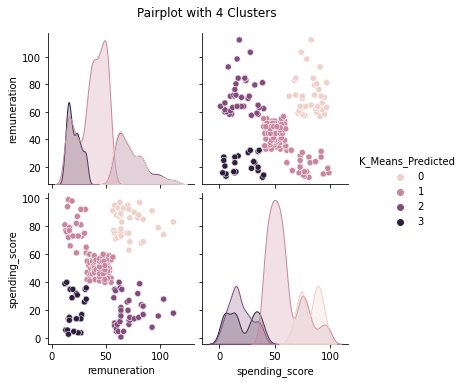

In [22]:
# Try 4 clusters
k_4_clusters = plot_k_clusters(4)

Number of customers in each cluster:
0    774
3    355
4    330
2    271
1    269
Name: K_Means_Predicted, dtype: int64


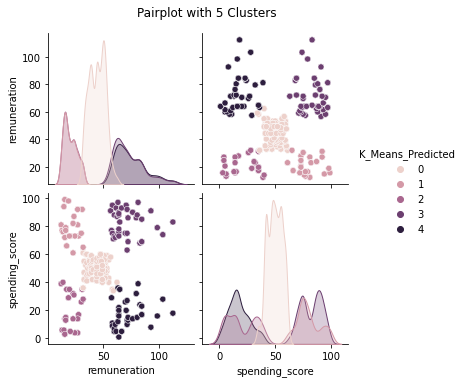

In [23]:
# Try 5 clusters
k_5_clusters = plot_k_clusters(5)

Number of customers in each cluster:
0    760
3    355
2    271
4    269
5    221
1    123
Name: K_Means_Predicted, dtype: int64


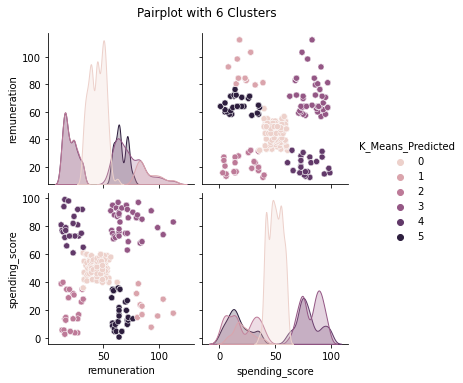

In [24]:
# Try 6 clusters
k_6_clusters = plot_k_clusters(6)

In [25]:
# Increase figure size 
sns.set(rc = {'figure.figsize':(12, 8)})

Text(0.5, 1.0, 'Scatterplot with K = 4')

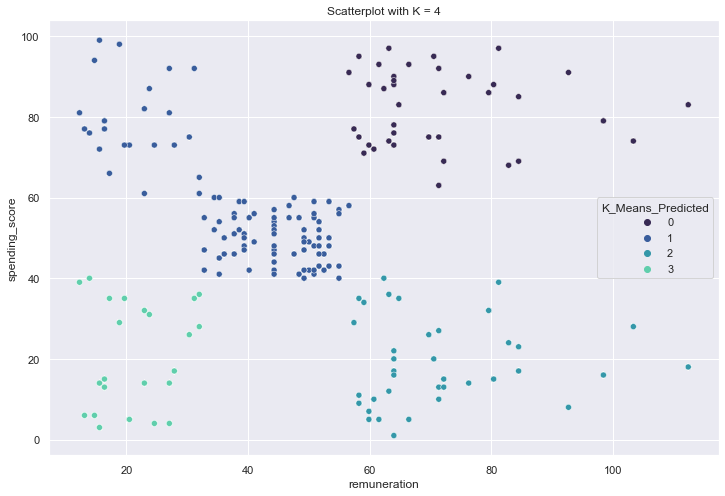

In [26]:
# View scatterplot for K = 4
sns.scatterplot(x='remuneration', y ='spending_score', data=k_4_clusters, hue='K_Means_Predicted', 
                palette=sns.color_palette('mako', n_colors=4)).set_title('Scatterplot with K = 4')

Text(0.5, 1.0, 'Scatterplot with K = 5')

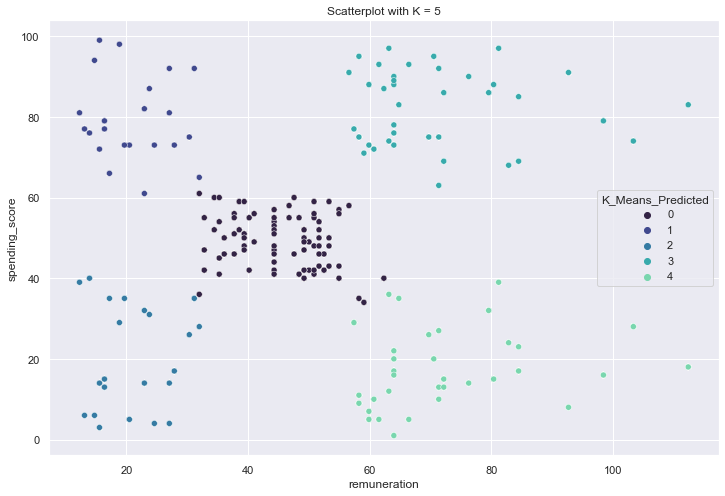

In [27]:
# View scatterplot for K = 5
sns.scatterplot(x='remuneration', y ='spending_score', data=k_5_clusters, hue='K_Means_Predicted', 
                palette=sns.color_palette('mako', n_colors=5)).set_title('Scatterplot with K = 5')

Text(0.5, 1.0, 'Scatterplot with K = 6')

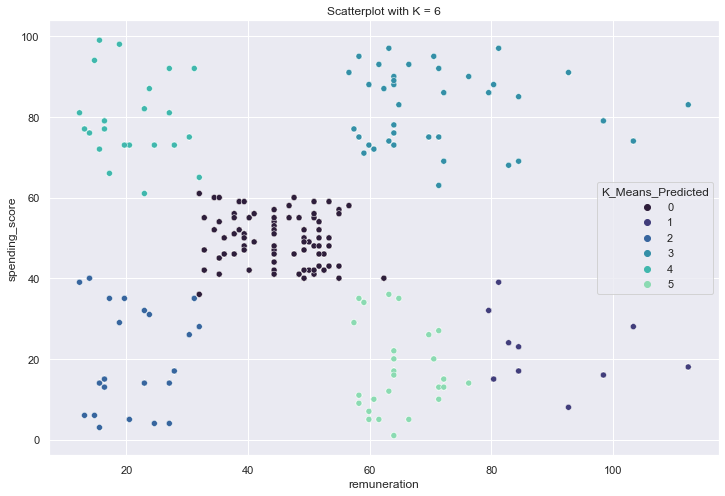

In [28]:
# View scatterplot for K = 6
sns.scatterplot(x='remuneration', y ='spending_score', data=k_6_clusters, hue='K_Means_Predicted', 
                palette=sns.color_palette('mako', n_colors=6)).set_title('Scatterplot with K = 6')

#### Summary 

The elbow method and silhouette method were utilised to determine the optimal number of clusters, or customer groups, with both methods indicating that 5 clusters would be optimal. Scatterplots displaying 4, 5, and 6 highlighted clusters also suggested that 5 groups would be optimal. 

Five different groups of customers have therefore been identified by remuneration and spending score. We suggest that each of these different groups can be targeted with specific marketing strategies. 


## Customer Reviews

Here we use sentiment analysis to investigate the sentiment in customer reviews. 

In [29]:
# Take the customer review data
nlp_df = reviews[['review', 'summary']]

In [30]:
# Set to lowercase
nlp_df['review'] = nlp_df['review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
nlp_df['summary'] = nlp_df['summary'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [31]:
# Remove punctuation
nlp_df['review'] = nlp_df['review'].str.replace('[^\w\s]','')
nlp_df['summary'] = nlp_df['summary'].str.replace('[^\w\s]','')

In [32]:
# Drop duplicated reviews 
nlp = nlp_df.drop_duplicates(subset=['review'])
nlp = nlp.drop_duplicates(subset=['summary'])
nlp.reset_index(inplace=True)
nlp.shape

(1349, 3)

In [33]:
# Tokenise words 
nlp['review_tokens'] = nlp['review'].apply(word_tokenize)
nlp['summary_tokens'] = nlp['summary'].apply(word_tokenize)

all_review_tokens = []
for i in range(nlp.shape[0]):
    all_review_tokens = all_review_tokens + nlp['review_tokens'][i]
all_summary_tokens = []
for i in range(nlp.shape[0]):
    all_summary_tokens = all_summary_tokens + nlp['summary_tokens'][i]

In [34]:
# Find the frequency of words 
freq_dist_reviews = FreqDist(all_review_tokens)
display(freq_dist_reviews)
freq_dist_summary = FreqDist(all_summary_tokens)
display(freq_dist_summary)

FreqDist({'the': 5019, 'and': 2934, 'to': 2843, 'a': 2829, 'of': 2261, 'i': 1887, 'it': 1830, 'is': 1593, 'this': 1549, 'for': 1360, ...})

FreqDist({'game': 268, 'the': 257, 'a': 238, 'great': 236, 'for': 229, 'to': 192, 'fun': 175, 'and': 168, 'it': 139, 'of': 131, ...})

In [35]:
# Remove non-alphanumerics
all_review_tokens_clean = [each_word for each_word in all_review_tokens if each_word.isalnum()]
all_summary_tokens_clean = [each_word for each_word in all_summary_tokens if each_word.isalnum()]

In [36]:
# Remove stopwords (and, the, etc...)
stopwords_eng = set(stopwords.words('english'))

all_review_tokens_clean = [each_word for each_word in all_review_tokens_clean \
                           if each_word.lower() not in stopwords_eng]
all_summary_tokens_clean = [each_word for each_word in all_summary_tokens_clean \
                           if each_word.lower() not in stopwords_eng]

In [37]:
# Convert tokens to string
review_string = ''
for token in all_review_tokens_clean:
    review_string = review_string + token + ' '
summary_string = ''
for token in all_summary_tokens_clean:
    summary_string = summary_string + token + ' '

In [38]:
# Function to create a word cloud

def create_wordcloud(data):
    sns.set(color_codes=True)
    
    wordcloud = WordCloud(width = 1600, height = 900, background_color ='white', 
                    colormap='winter', min_font_size = 12).generate(data) 
    
    plt.figure(figsize = (16, 9), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis('off') 
    plt.tight_layout(pad = 0) 
    
    return plt.show()

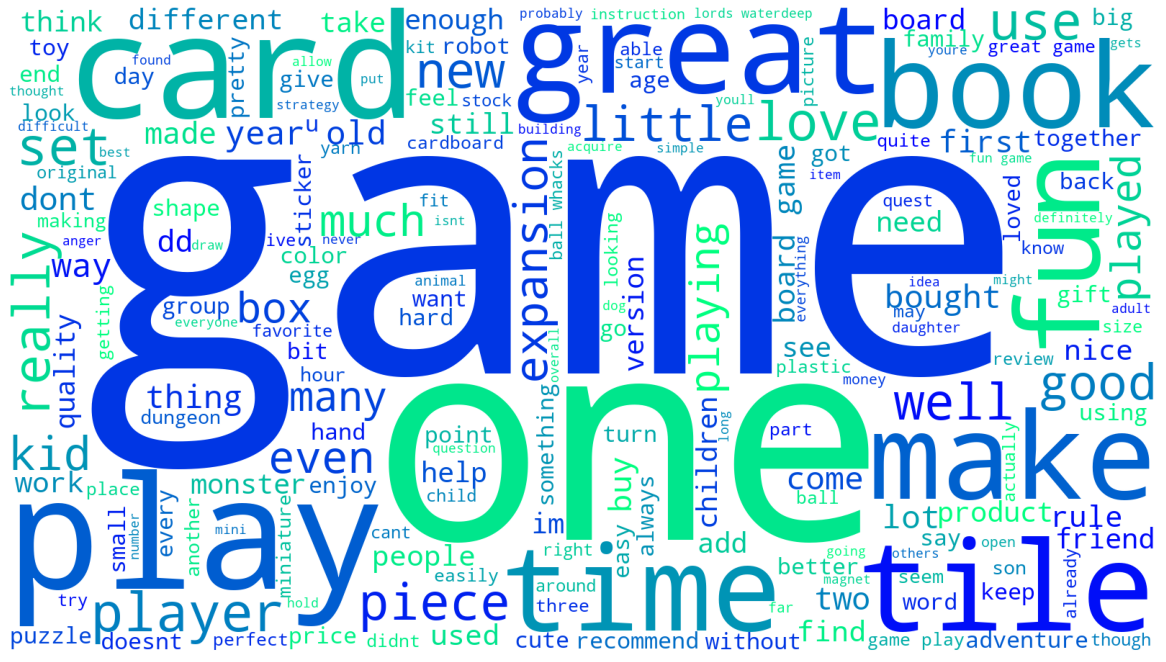

In [39]:
# Word cloud for reviews
create_wordcloud(review_string)

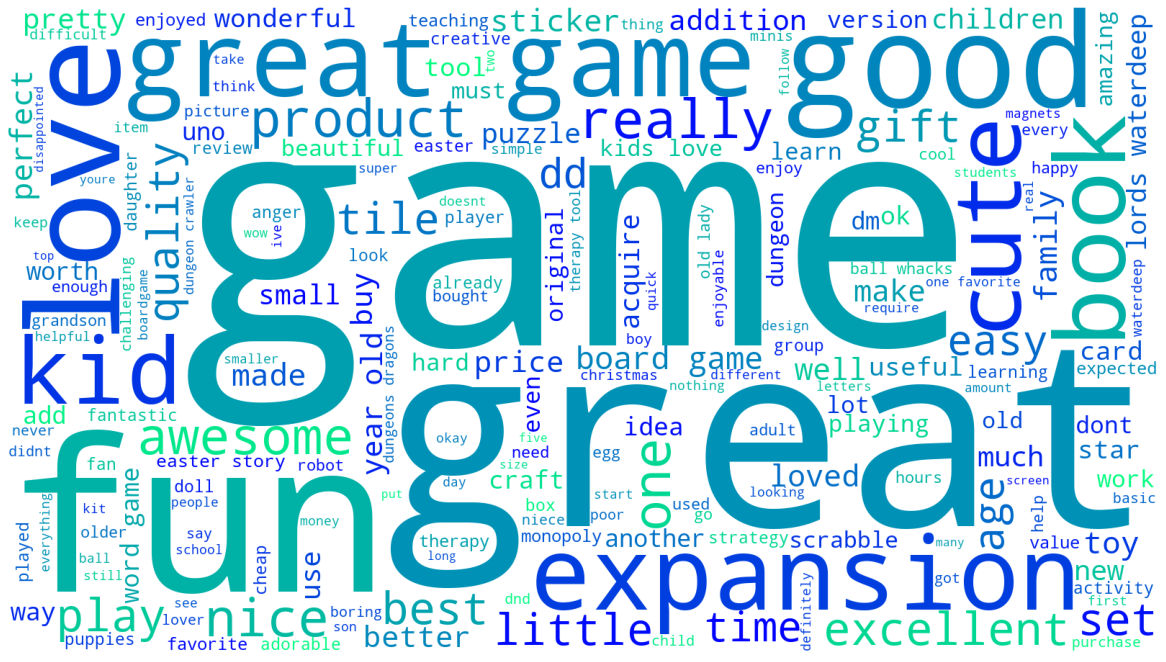

In [40]:
# Word cloud for summary
create_wordcloud(summary_string)

In [41]:
# Find frequency of words (clean data)
freq_dist_reviews_clean = FreqDist(all_review_tokens_clean)
display(freq_dist_reviews_clean)
freq_dist_summary_clean = FreqDist(all_summary_tokens_clean)
display(freq_dist_summary_clean)

FreqDist({'game': 1359, 'one': 475, 'play': 442, 'fun': 407, 'great': 391, 'like': 373, 'get': 293, 'cards': 281, 'tiles': 280, 'really': 278, ...})

FreqDist({'game': 268, 'great': 236, 'fun': 175, 'good': 84, 'love': 70, 'like': 54, 'kids': 48, 'book': 42, 'expansion': 42, 'cute': 40, ...})

In [42]:
# Most common words 
most_common_review = pd.DataFrame(Counter(all_review_tokens_clean).most_common(15), columns=['Word', 'Count']).set_index('Word')
most_common_summary = pd.DataFrame(Counter(all_summary_tokens_clean).most_common(15), columns=['Word', 'Count']).set_index('Word')

In [43]:
# Function to plot frequency of words 
def plot_common_words(data, colour, describe_data):
    ax = data.plot(kind='barh', colormap=colour)
    ax.set_xlabel('Count')
    ax.set_title(f'Count of the 15 Most Common Words in {describe_data}')
    for i in ax.patches:
        ax.text(i.get_width()+5, i.get_y()+.1, str((i.get_width())))

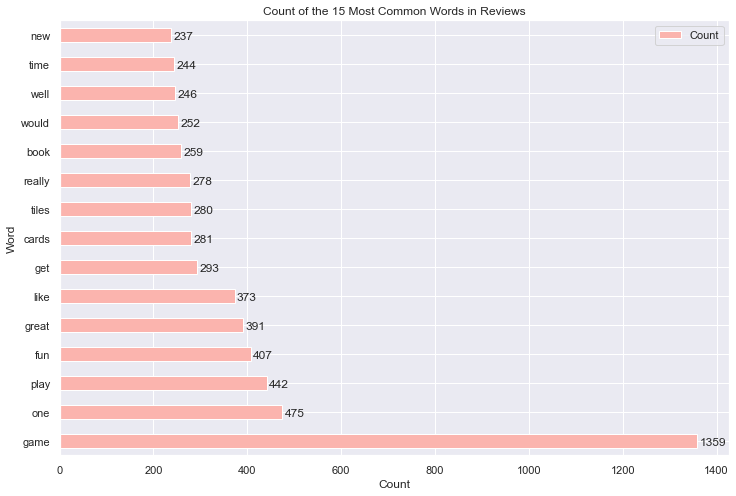

In [44]:
# Most common words in reviews 
plot_common_words(most_common_review, 'Pastel1', 'Reviews')

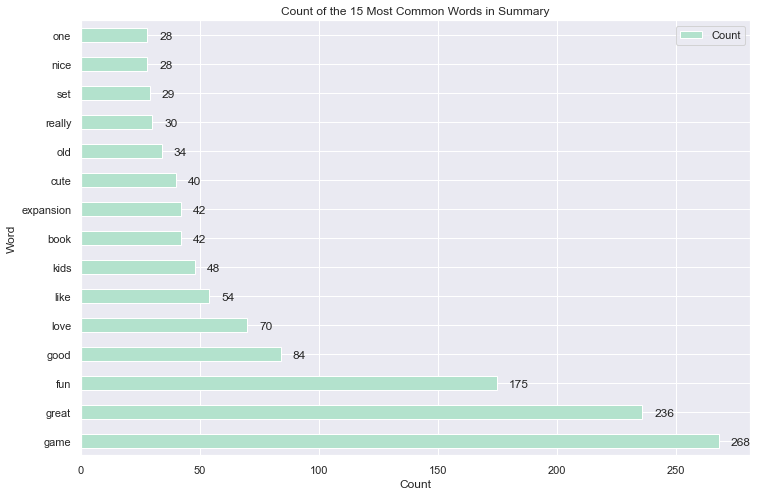

In [45]:
# Most common words in summary 
plot_common_words(most_common_summary, 'Pastel2', 'Summary')

In [46]:
# Calculate the sentiment polarity
def generate_sentiment_polarity(text):
    return TextBlob(text).sentiment[0]

nlp['review_polarity'] = nlp['review'].apply(generate_sentiment_polarity)
nlp['summary_polarity'] = nlp['summary'].apply(generate_sentiment_polarity)

print(nlp['review_polarity'].describe(),'\n')
print(nlp['summary_polarity'].describe())

count    1349.000000
mean        0.181170
std         0.225455
min        -1.000000
25%         0.040476
50%         0.153571
75%         0.308889
max         1.000000
Name: review_polarity, dtype: float64 

count    1349.000000
mean        0.271704
std         0.349649
min        -1.000000
25%         0.000000
50%         0.250000
75%         0.500000
max         1.000000
Name: summary_polarity, dtype: float64


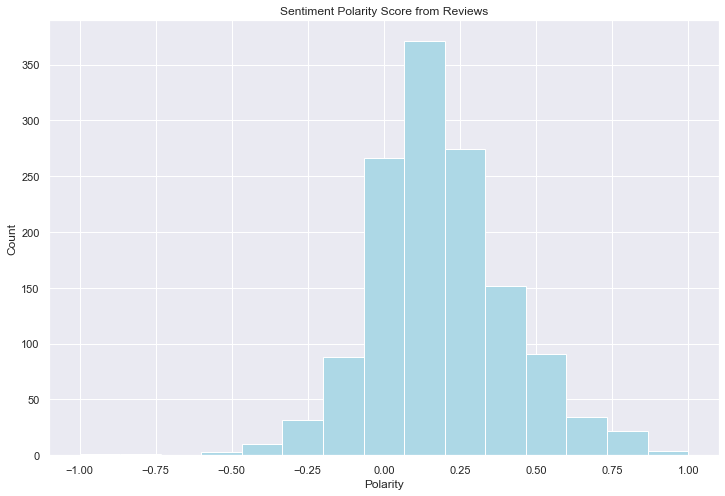

In [47]:
# Plot sentiment polarity for reviews
plt.hist(nlp['review_polarity'], bins=15, facecolor='lightblue')
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Sentiment Polarity Score from Reviews')
plt.show()

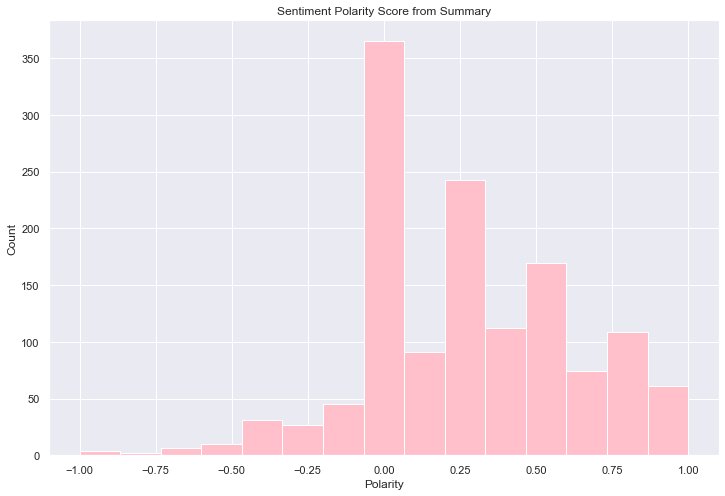

In [48]:
# Plot sentiment polarity for summary
plt.hist(nlp['summary_polarity'], bins=15, facecolor='pink')
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Sentiment Polarity Score from Summary')
plt.show()

In [49]:
# Get top 20 positive and negative
top_20_positive_reviews = nlp.sort_values(by='review_polarity', ascending=False).head(20)[['review_polarity', 'review']]
top_20_negative_reviews = nlp.sort_values(by='review_polarity').head(20)[['review_polarity', 'review']]
top_20_positive_summary = nlp.sort_values(by='summary_polarity', ascending=False).head(20)[['summary_polarity', 'summary']]
top_20_negative_summary = nlp.sort_values(by='summary_polarity').head(20)[['summary_polarity', 'summary']]

In [50]:
# Show top 20 positive reviews 
with pd.option_context('display.max_colwidth', -1):
    display(top_20_positive_reviews)

,review_polarity,review
564,1.000000,perfect
1080,1.000000,my daughter loves her stickers awesome seller thank you
1334,1.000000,perfect for tutoring my grandson in spelling
890,0.880000,the best part i see is the box what a wonderfully diverse and rounded set for the cost i am so happy and as the dm you know that if i am happy my players are happy
498,0.816667,great quality very cute and perfect for my toddler
1333,0.800000,this is a great tool to have at hand when playing quiddler
336,0.800000,great seller happy with my purchase 5 starrrr
1287,0.800000,prompt service and a great product
1187,0.800000,a great creation tool it helps me concentrate
824,0.800000,husband seems happy with it


In [51]:
# Show top 20 negative reviews 
with pd.option_context('display.max_colwidth', -1):
    display(top_20_negative_reviews)

,review_polarity,review
165,-1.000000,booo unles you are patient know how to measure i didnt have the patience neither did my daughter boring unless you are a craft person which i am not
147,-0.780000,incomplete kit very disappointing
267,-0.550000,one of my staff will be using this game soon so i dont know how well it works as yet but after looking at the cards i believe it will be helpful in getting a conversation started regarding anger and what to do to control it
90,-0.500000,i bought this as a christmas gift for my grandson its a sticker book so how can i go wrong with this gift
141,-0.491667,i sent this product to my granddaughter the pompom maker comes in two parts and is supposed to snap together to create the pompoms however both parts were the same making it unusable if you cant make the pompoms the kit is useless since this was sent as a gift i do not have it to return very disappointed
251,-0.446250,my 8 yearold granddaughter and i were very frustrated and discouraged attempting this craft it is definitely not for a young child i too had difficulty understanding the directions we were very disappointed
382,-0.440741,i purchased this on the recommendation of two therapists working with my adopted children the children found it boring and put it down half way through
713,-0.400000,if you like me used to play dd but now you and your friends growed up and cant be together because all the responsibilities and bla bla bla this game is for you come to the dungeon
1011,-0.400000,you can play the expansions one at a time or add then both in for a longer game if your into lords of waterdeep this is a must have
355,-0.400000,my son loves playing this game it was recommended by a counselor at school that works with him


In [52]:
# Show top 20 positive summary 
with pd.option_context('display.max_colwidth', -1):
    display(top_20_positive_summary)

,summary_polarity,summary
150,1.0,awesome
541,1.0,perfect tool for learning how to tell time one on one with your child
337,1.0,excellent
581,1.0,one of the best games ever
1080,1.0,awesome seller thank you
776,1.0,best dungeon crawler
1078,1.0,loves stickers and she loves peppa so this was perfect
982,1.0,awesome expansion
720,1.0,best one in the series
737,1.0,excellent introduction to dungeons and dragons


In [53]:
# Show top 20 negative summary 
with pd.option_context('display.max_colwidth', -1):
    display(top_20_negative_summary)

,summary_polarity,summary
165,-1.000000,boring unless you are a craft person which i am
587,-1.000000,boring
17,-1.000000,the worst value ive ever seen
837,-0.900000,before this i hated running any rpg campaign dealing with towns because it
1,-0.800000,another worthless dungeon masters screen from galeforce9
116,-0.750000,disappointed
266,-0.700000,promotes anger instead of teaching calming methods
637,-0.700000,bad qualityall made of paper
634,-0.700000,too bad this is not what i was expecting
144,-0.650000,at age 31 i found these very difficult to make


In [54]:
# Get top 10 products by average review polarity  

product_id = []
mean_review_polarity = []
count = []

for each_product in set(reviews['product']):
    
    product_index = reviews[reviews['product']==each_product].index
    product_mean = nlp[nlp['index'].isin(product_index)].review_polarity.mean()
    product_count = nlp[nlp['index'].isin(product_index)].review_polarity.count()
    
    product_id.append(each_product)
    mean_review_polarity.append(product_mean)
    count.append(product_count)
    
means_df = pd.DataFrame(list(zip(product_id, mean_review_polarity, count)), 
                        columns=['product', 'mean_review_polarity', 'number_of_reviews'])

top_products = means_df.sort_values(by='mean_review_polarity', ascending=False)[:10].reset_index(drop=True)
top_products

,product,mean_review_polarity,number_of_reviews
0,11004,0.437552,4
1,9119,0.397751,6
2,2139,0.385115,7
3,3158,0.383138,6
4,326,0.359691,7
5,515,0.353342,9
6,6310,0.350492,8
7,2457,0.347050,6
8,466,0.346270,3
9,11086,0.341155,6


#### Summary 

The sentiment from customers is slightly positive overall (average review polarity score = 0.18), with more strong positive reviews than strong negative reviews. The words 'fun' and 'great' are in the top 5 most common words from reviews. 

Further analysis is recommended to investigate common themes across the top 20 positive and negative scores. For example, we notice that the top 20 postive reviews include multiple mentions of the word 'tool'. 

We have also identified the top 10 products by average review polarity. A limitation here is that duplicate reviews and summaries have been excluded. Therefore, where there are several identical positive reviews, the positive sentiment is only captured once.

# Conclusions

Key results from the customer data:

- Customer loyalty points are associated with age, remuneration, spending score, and gender. 
- Five distinct customer groups were identified using remuneration and spending score. 
- Customer sentiment from reviews is on average positive, with 'fun' and 'great' appearing in the top 5 most common words.

For further detail, please refer to the full report. 